 ### Goal: Wrangle WeRateDogs Twitter data to create interesting and unbiased analyses and visualizations.
 * WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage"(there are 2356), retweet count and favorite count are two of the notable column omissions.query Twitter's API to gather this valuable data.
  * We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.  
  * Clean at least 8 quality issues 
  * Cleaning includes merging individual pieces of data according to the rules of tidy data. 
  * and at least 2 tidiness issues in this dataset. That is messy data (structrally wrong) and wrong data. (Ones that doesn't belong in there)


In [1]:
import pandas as pd
import requests
import json
import numpy as np
import re
import tweepy
import seaborn as sns
import matplotlib.pyplot as plt

# Gather

In [2]:
df = pd.read_csv('twitter-archive-enhanced.csv')

In [40]:
df1_clean=df

In [41]:
df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [42]:
df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [3]:
####  This section is to gather data from Tweeter. from 
#### which twitter JSon file is created using  Consumer 
####  Key and tokens are obtained in order to run this 
####  program through Account made from Tweeter. 
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

#### Secret keys and tokens are blanked out
consumer_key = 'xxxxxx'
consumer_secret = 'xxxxxxld6FzdbKkQ3lKXGhJFZ0'
access_token = '1xxxxxxxwAqOjB22IgZYeu'
access_secret = 'xxxxxxxXrRMmZYlLZDCvzL'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df.tweet_id.values
len(tweet_ids)

###  Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
#### Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

In [43]:
# load json data into pandas DataFrame
text_file_path = 'tweet_json.txt'
tweet_json_df = pd.read_json(text_file_path, lines = True)
# extract columns that pertain to like and favorite counts
columns_of_interest = ['id', 'retweet_count', 'favorite_count']
tweet_likes_df = tweet_json_df[columns_of_interest]

In [44]:
tweet_likes_df.head(3)

,id,retweet_count,favorite_count
0,892420643555336193,8311,38001
1,892177421306343426,6139,32630
2,891815181378084864,4064,24549


In [45]:
tweet_likes_df.nunique()

id                2340
retweet_count     1738
favorite_count    1994
dtype: int64

In [46]:
df2_clean = tweet_likes_df

In [47]:
df2_clean.sample(3)

,id,retweet_count,favorite_count
152,861005113778896900,3844,16780
987,747885874273214464,1056,3095
1390,699323444782047232,918,3305


In [48]:
df1_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [49]:
df2_clean.rename(columns = {'id':'tweet_id'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [50]:
df2_clean.columns

Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')

In [51]:
## getting image predictions file

tsv_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(tsv_url)

with open(tsv_url.split('/')[-1], mode = 'wb') as file:
    file.write(r.content)
    
image_pred = pd.read_csv('image-predictions.tsv', sep = '\t')
image_pred.head(5) 


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


  * Issue - Files from twitter-archive-enhance.csv needs to be merged with JSon file

  * Solution
1. Cleaning - Merging tweet_likes_df to df1_clean which will include retweet_count and favorite_count (Json file) joining on tweet_id


In [52]:
df1_clean=pd.merge(left=df1_clean,right=df2_clean,on='tweet_id',how='left')

In [53]:
df1_clean=pd.merge(left=df1_clean,right=image_pred,on='tweet_id',how='left')

In [54]:
df1_clean.to_csv('df1_clean_copy.csv',encoding = 'utf-8')

In [55]:
df1_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

In [56]:
df1_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [57]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 23

In [58]:
df1_clean.retweet_count

0        8311.0
1        6139.0
2        4064.0
3        8455.0
4        9154.0
5        3046.0
6        2018.0
7       18435.0
8        4182.0
9        7214.0
10       7170.0
11       4864.0
12       9819.0
13       4433.0
14       2198.0
15       5253.0
16       4401.0
17       4192.0
18       3471.0
19          NaN
20       3415.0
21       5275.0
22      11420.0
23      17766.0
24      10171.0
25       5832.0
26       7602.0
27       3209.0
28       4363.0
29       3130.0
         ...   
2326      323.0
2327       40.0
2328       84.0
2329       90.0
2330      562.0
2331       71.0
2332      133.0
2333       90.0
2334      347.0
2335       64.0
2336       76.0
2337       35.0
2338     6430.0
2339       12.0
2340       66.0
2341       72.0
2342       44.0
2343      160.0
2344       59.0
2345      213.0
2346       57.0
2347      139.0
2348      237.0
2349      837.0
2350       59.0
2351       41.0
2352      139.0
2353       43.0
2354       47.0
2355      501.0
Name: retweet_count, Len

 * Issue - timestamped is not in date format

  * Solution
#### Tidy 1. Timestamped must be converted to date format

In [59]:


df1_clean['timestamp'] = pd.to_datetime(df1_clean['timestamp'])


  * Check

In [60]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count           

  * Issue - Remove retweeted_status_id which are empty

In [61]:

# Clean 2 Solution is to remove retweeted_status_id which are nulls
df1_clean = df1_clean[pd.isnull(df1_clean['retweeted_status_id'])]
df1_clean.shape[0]

2175

  * Issue - We don't need columns for in_reply_to_status_id and in_reply_to_user_id

In [62]:
# Clean 3 Solution is to remove in_reply_to_status_id and in_reply_to_user_id
df1_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)


  * Issue - We don't need retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp

In [63]:
## Cleanup 4 Solution We will delete retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp
df1_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)


  * Issue - We will only eliminate the records that doesn't have pictures.

In [64]:
## Cleanup 5 Solution is to delete any items which doesn't have any pictures
df1_clean=df1_clean[pd.notnull(df1_clean['jpg_url'])]


  * Check

In [65]:
df1_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
retweet_count         1992 non-null float64
favorite_count        1992 non-null float64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               19

  * Issue - We need to consolidate 4 unnecessary columns (pupper', 'puppo', 'doggo', 'floofer') to 1 column (dog_kind)

####  Cleaning 6 Solution - Since we don't need 4 columns of the dog types, we want to just have 1 column for the dog type

In [66]:
dog_kind = []

x = ['pupper', 'puppo', 'doggo', 'floofer']
y = ['pupper', 'puppo', 'doggo', 'floofer']

for row in df1_clean['text']:
    row = row.lower()
    for word in x:
        if word in str(row):
            dog_kind.append(y[x.index(word)])
            break
    else:
        dog_kind.append('None')

df1_clean['dog_kind'] = dog_kind

In [67]:
df1_clean['dog_kind'].value_counts()

None       1652
pupper      237
doggo        69
puppo        29
floofer       7
Name: dog_kind, dtype: int64

  * Issue - We need to delete unnecessary dog type columns

In [68]:
# Cleaning 7  Solution - we will remove unnecessary columns
df1_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)


  * Check

In [69]:
# Lets see the final version of clean data
df1_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count',
       'favorite_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'dog_kind'],
      dtype='object')

In [70]:
df1_clean.head(10)


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_kind
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8311.0,38001.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6139.0,32630.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4064.0,24549.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8455.0,41351.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9154.0,39530.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,3046.0,19861.0,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,None
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,2018.0,11606.0,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,None
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,18435.0,64126.0,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,None
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,4182.0,27277.0,...,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,None
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,7214.0,31302.0,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,doggo


In [71]:
df1_clean.nunique()

tweet_id              1994
timestamp             1994
source                   3
text                  1994
expanded_urls         1994
rating_numerator        34
rating_denominator      15
name                   936
retweet_count         1601
favorite_count        1843
jpg_url               1994
img_num                  4
p1                     374
p1_conf               1991
p1_dog                   2
p2                     401
p2_conf               1989
p2_dog                   2
p3                     405
p3_conf               1991
p3_dog                   2
dog_kind                 5
dtype: int64

  * Issue - Only use records that has tweet ids

#### Cleaning 8 Solution - get rid of all records that has a null tweet_ids

In [72]:
df1_clean=df1_clean[df1_clean.tweet_id.notnull()]


In [73]:
df1_clean


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_kind
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8311.0,38001.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6139.0,32630.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4064.0,24549.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8455.0,41351.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9154.0,39530.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,3046.0,19861.0,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,None
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,2018.0,11606.0,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,None
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,18435.0,64126.0,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,None
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,4182.0,27277.0,...,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,None
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,7214.0,31302.0,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,doggo


In [74]:
df1_clean.name.nunique()

936

  * Issue - There are erroneous names which are in lower case like 'a','such'.. These are not valid names

  * Tidy 2 Solution - These names will be replaced with NaN

In [75]:
df1_clean.loc[df1_clean.name.str.islower(),'name']='None'
df1_clean.name=df1_clean.name.replace('None',np.nan)

In [76]:
df1_clean.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5            NaN
6            Jax
7            NaN
8           Zoey
9         Cassie
10          Koda
11         Bruno
12           NaN
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
20        Gerald
21       Jeffrey
22           NaN
23        Canela
24           NaN
25           NaN
26          Maya
27        Mingus
28         Derek
29        Roscoe
31       Waffles
          ...   
2326         NaN
2327         NaN
2328         NaN
2329         NaN
2330         NaN
2331         NaN
2332         NaN
2333         NaN
2334         NaN
2335         NaN
2336         NaN
2337         NaN
2338         NaN
2339         NaN
2340         NaN
2341         NaN
2342         NaN
2343         NaN
2344         NaN
2345         NaN
2346         NaN
2347         NaN
2348         NaN
2349         NaN
2350         NaN
2351         NaN
2352         NaN
2353         N

  * Issue There are several issues with the rating_numerator and rating_denominator. Namely, the rating_numerator should not be more than 30 (because we will be calculating the ratings which is numerator/denominator and it should not be more than 3). And the rating_denominator must always be consistently be 10.

In [77]:
df1_clean.loc[df1_clean.rating_numerator > 30,['tweet_id','rating_numerator']]


,tweet_id,rating_numerator
433,820690176645140481,84
695,786709082849828864,75
902,758467244762497024,165
979,749981277374128128,1776
1120,731156023742988288,204
1202,716439118184652801,50
1228,713900603437621249,99
1254,710658690886586372,80
1274,709198395643068416,45
1351,704054845121142784,60


#### Cleaning 8 Solution - alter these rating_numerator records so that it is more congruent to all data collected

In [78]:
df1_clean.loc[df1_clean.tweet_id==786709082849828864,['rating_numerator','rating_denominator']]=[7,10]


In [79]:
df1_clean=df1_clean[df1_clean.tweet_id!= 749981277374128128]


In [80]:
df1_clean=df1_clean[df1_clean.tweet_id!= 670842764863651840]

In [81]:
### There are errors in the rating_denominator which should be 10
### that we should correct them
df1_clean.loc[df1_clean.rating_denominator != 10,['tweet_id','rating_numerator','rating_denominator']]


,tweet_id,rating_numerator,rating_denominator
433,820690176645140481,84,70
516,810984652412424192,24,7
902,758467244762497024,165,150
1068,740373189193256964,9,11
1120,731156023742988288,204,170
1165,722974582966214656,4,20
1202,716439118184652801,50,50
1228,713900603437621249,99,90
1254,710658690886586372,80,80
1274,709198395643068416,45,50


In [82]:
### I have decided to make the rating_numerator to be a maximum of
### 30 so that my modified rating which is(rating_numerator/rating_denominator)
### should be a maximum of 3. This would eliminate outliers

In [83]:
df1_clean.loc[df1_clean.tweet_id==820690176645140481,['rating_numerator','rating_denominator']]=[11,10]


In [84]:
df1_clean.loc[df1_clean.tweet_id==820690176645140481,['rating_numerator','rating_denominator']]=[12,10]
df1_clean.loc[df1_clean.tweet_id==810984652412424192,['rating_numerator','rating_denominator']]=[24,10]
df1_clean.loc[df1_clean.tweet_id==758467244762497024,['rating_numerator','rating_denominator']]=[11,10]
df1_clean.loc[df1_clean.tweet_id==740373189193256964,['rating_numerator','rating_denominator']]=[9,10]
df1_clean.loc[df1_clean.tweet_id==731156023742988288,['rating_numerator','rating_denominator']]=[12,10]

df1_clean.loc[df1_clean.tweet_id==722974582966214656,['rating_numerator','rating_denominator']]=[4,10]
df1_clean.loc[df1_clean.tweet_id==716439118184652801,['rating_numerator','rating_denominator']]=[10,10]
df1_clean.loc[df1_clean.tweet_id==713900603437621249,['rating_numerator','rating_denominator']]=[11,10]
df1_clean.loc[df1_clean.tweet_id==710658690886586372,['rating_numerator','rating_denominator']]=[10,10]
df1_clean.loc[df1_clean.tweet_id==709198395643068416,['rating_numerator','rating_denominator']]=[9,10]

df1_clean.loc[df1_clean.tweet_id==704054845121142784,['rating_numerator','rating_denominator']]=[12,10]
df1_clean.loc[df1_clean.tweet_id==697463031882764288,['rating_numerator','rating_denominator']]=[11,10]
df1_clean.loc[df1_clean.tweet_id==684225744407494656,['rating_numerator','rating_denominator']]=[11,10]
df1_clean.loc[df1_clean.tweet_id==684222868335505415,['rating_numerator','rating_denominator']]=[7,10]
df1_clean.loc[df1_clean.tweet_id==677716515794329600,['rating_numerator','rating_denominator']]=[11,10]

df1_clean.loc[df1_clean.tweet_id==675853064436391936,['rating_numerator','rating_denominator']]=[11,10]
df1_clean.loc[df1_clean.tweet_id==666287406224695296,['rating_numerator','rating_denominator']]=[11,10]


  * Issue - we have to eliminate all records that have retweets

In [85]:
# Cleaning 9 - solution - remote the text lines containing RT we don't want retweets
df1_clean = df1_clean[~df1_clean['text'].str.contains("RT @")]

In [86]:
#check
df1_clean[df1_clean['text'].str.contains("RT @")]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_kind


In [87]:

#check if there are any duplicates
sum(df1_clean.duplicated())


0

  * The highest rating given to a dog is 27 and the most rated number given was a 12

In [88]:
#highest rated dog
df1_clean['rating_numerator'].value_counts()

12    453
10    421
11    403
13    261
9     152
8      95
7      54
14     35
5      33
6      32
3      19
4      16
2       9
1       4
0       2
26      1
24      1
27      1
Name: rating_numerator, dtype: int64

  * Issue - We need to change the format for timestamp to a date format

#### Cleaning 10 Solution - Change the timestamp in date format

In [89]:
df1_clean['timestamp'] = pd.to_datetime(df1_clean['timestamp'])


### Store

In [90]:
df1_clean.to_csv('twitter_archive_master.csv')

### Analysis


  * The top 3 dogs that were successfully predicted are :
  * 1. The Golden Retriever
  * 2. The Labrador Retriever
  * 3. The Golden Retriever again


In [91]:
df1_clean[df1_clean.p1_dog==True].p1.describe()

count                 1477
unique                 111
top       golden_retriever
freq                   139
Name: p1, dtype: object

In [92]:
df1_clean[df1_clean.p2_dog==True].p2.describe()

count                   1495
unique                   113
top       Labrador_retriever
freq                      96
Name: p2, dtype: object

In [93]:
df1_clean[df1_clean.p3_dog==True].p3.describe()

count                   1446
unique                   116
top       Labrador_retriever
freq                      76
Name: p3, dtype: object

  * The top 3 items or dog that were falsely identified are :
  * Seat belt
  * Doormat
  * Dingo

In [94]:
df1_clean[df1_clean.p1_dog==False].p1.describe()

count           515
unique          262
top       seat_belt
freq             21
Name: p1, dtype: object

In [95]:
df1_clean[df1_clean.p2_dog==False].p2.describe()

count           497
unique          287
top       seat_belt
freq             11
Name: p2, dtype: object

In [96]:
df1_clean[df1_clean.p3_dog==False].p3.describe()

count       546
unique      287
top       dingo
freq         15
Name: p3, dtype: object

  * The best kind of dog that are popular belongs to the category of   'pupper'

In [97]:
df1_clean.dog_kind.value_counts()

None       1650
pupper      237
doggo        69
puppo        29
floofer       7
Name: dog_kind, dtype: int64

In [98]:
df1_clean.name.value_counts()

Charlie         11
Lucy            10
Cooper          10
Oliver          10
Penny            9
Tucker           9
Sadie            8
Winston          8
Toby             7
Daisy            7
Lola             7
Koda             6
Stanley          6
Bo               6
Jax              6
Bella            6
Leo              5
Buddy            5
Milo             5
Louis            5
Dave             5
Scout            5
Bailey           5
Oscar            5
Chester          5
Rusty            5
Gary             4
George           4
Clark            4
Duke             4
                ..
Rumble           1
Kuyu             1
Coopson          1
Clifford         1
Lilah            1
Keet             1
Gustaf           1
Willy            1
Nigel            1
Creg             1
Lilli            1
Autumn           1
Margo            1
Ralphus          1
Samsom           1
Jett             1
Pinot            1
Chesterson       1
Chevy            1
Chadrick         1
Jessiga          1
Leonidas    

### Visualizing

In [99]:


df1_clean = pd.read_csv('twitter_archive_master.csv')

In [100]:
df1_clean.columns

Index(['Unnamed: 0', 'tweet_id', 'timestamp', 'source', 'text',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_kind'],
      dtype='object')

In [101]:
df1_clean.set_index('timestamp', inplace=True)
df1_clean['ratings'] = df1_clean['rating_numerator']/df1_clean['rating_denominator']


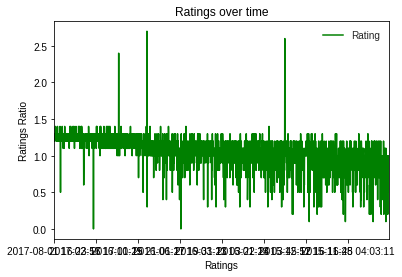

In [102]:
df1_clean['ratings'].plot(color = 'green', label='Rating')
###df1_clean['favorite_count'].plot(color = 'blue', label='Favorites')
plt.style.use('seaborn-darkgrid')
plt.legend(loc='upper right')
plt.xlabel('Ratings')
plt.ylabel('Ratings Ratio')
plt.title('Ratings over time')
plt.savefig('Ratings.png')
plt.show()

In [103]:
df1_clean[df1_clean.ratings> 2.5].dog_kind

timestamp
2016-09-20 00:24:34    pupper
2015-12-25 21:06:00    pupper
Name: dog_kind, dtype: object

In [104]:
df1_clean[df1_clean.ratings> 2.5].name

timestamp
2016-09-20 00:24:34    Sophie
2015-12-25 21:06:00       NaN
Name: name, dtype: object

  * The top most rating occured in 09-20-2016 and in 12-25-2015
    They are both puppers and the name is Sophie and the other 
    is unknown.
    

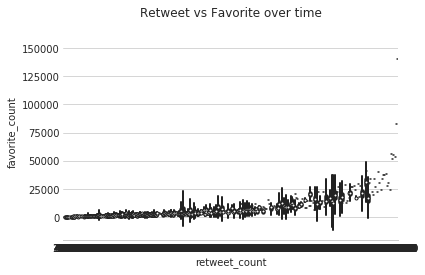

In [118]:
sns.set_style("whitegrid")
sns.violinplot(x=df1_clean['retweet_count'], y=df1_clean['favorite_count'], palette="Blues")
sns.despine(left=True)
plt.title('Retweet vs Favorite over time')
plt.savefig('RetweetsnFavorite.png')

  * From the plot above, we can deduce that the retweet counts increases sharply with the favorite counts over time.